In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import os, sys

# Folder in your Drive (inside "My Drive")
FOLDERNAME = "assignment1/cs231n"
assert FOLDERNAME, "[!] Enter the foldername."

# Build paths (this is the OLD Drive style: /content/gdrive/My Drive/...)
ROOT = f"/content/gdrive/My Drive/{FOLDERNAME}"
DATASETS = os.path.join(ROOT, "datasets")

# Add assignment folder to Python path
if ROOT not in sys.path:
    sys.path.append(ROOT)

# Sanity checks
if not os.path.isdir(ROOT):
    raise FileNotFoundError(
        f"Can't find assignment folder at:\n  {ROOT}\n"
        "Check that FOLDERNAME matches your Drive folder structure."
    )

if not os.path.isdir(DATASETS):
    raise FileNotFoundError(
        f"Can't find datasets folder at:\n  {DATASETS}\n"
        "Make sure the 'datasets' folder exists inside the assignment folder."
    )

# Go to datasets and download CIFAR-10
%cd "{DATASETS}"

if not os.path.isfile("get_datasets.sh"):
    raise FileNotFoundError(
        "get_datasets.sh not found in datasets/. "
        "You're either in the wrong folder or missing assignment files."
    )

!bash get_datasets.sh

# Return to assignment root
%cd "{ROOT}"

Mounted at /content/gdrive
/content/gdrive/My Drive/assignment1/cs231n/datasets
/content/gdrive/My Drive/assignment1/cs231n


In [2]:
import sys
sys.path.append("/content/gdrive/My Drive/assignment1")

# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [4]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'



## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [9]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [10]:
from cs231n.features import *

# num_color_bins = 10 # Number of bins in the color histogram
num_color_bins = 25 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train Softmax classifier on features
Using the Softmax code developed earlier in the assignment, train Softmax classifiers on top of the features extracted above; this should achieve better results than training them directly on top of raw pixels.

In [20]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import Softmax

learning_rates = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2]

regularization_strengths = [1e0, 1e1, 1e2, 3e2, 1e3, 3e3, 1e4]


results = {}
best_val = -1
best_softmax = None
for lr in learning_rates:
  for reg in regularization_strengths:
    model = Softmax()
    model.train(X=X_train_feats, y=y_train, learning_rate=lr, reg=reg)
    y_train_pred = model.predict(X_train_feats)
    y_val_pred = model.predict(X_val_feats)
    train_accuracy =(y_train_pred == y_train).mean()
    val_accuracy = (y_val_pred == y_val).mean()
    results[(lr, reg)] = (train_accuracy, val_accuracy)
    if val_accuracy > best_val:
      best_val = val_accuracy
      best_softmax = model

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the Softmax; save#
# the best trained classifer in best_softmax. If you carefully tune the model, #
# you should be able to get accuracy of above 0.42 on the validation set.      #
################################################################################


# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved: %f' % best_val)

lr 1.000000e-04 reg 1.000000e+00 train accuracy: 0.203408 val accuracy: 0.220000
lr 1.000000e-04 reg 1.000000e+01 train accuracy: 0.229898 val accuracy: 0.233000
lr 1.000000e-04 reg 1.000000e+02 train accuracy: 0.356959 val accuracy: 0.366000
lr 1.000000e-04 reg 3.000000e+02 train accuracy: 0.419224 val accuracy: 0.422000
lr 1.000000e-04 reg 1.000000e+03 train accuracy: 0.401531 val accuracy: 0.388000
lr 1.000000e-04 reg 3.000000e+03 train accuracy: 0.372347 val accuracy: 0.387000
lr 1.000000e-04 reg 1.000000e+04 train accuracy: 0.104714 val accuracy: 0.116000
lr 3.000000e-04 reg 1.000000e+00 train accuracy: 0.326633 val accuracy: 0.317000
lr 3.000000e-04 reg 1.000000e+01 train accuracy: 0.369571 val accuracy: 0.360000
lr 3.000000e-04 reg 1.000000e+02 train accuracy: 0.423367 val accuracy: 0.427000
lr 3.000000e-04 reg 3.000000e+02 train accuracy: 0.404694 val accuracy: 0.403000
lr 3.000000e-04 reg 1.000000e+03 train accuracy: 0.376469 val accuracy: 0.374000
lr 3.000000e-04 reg 3.000000

In [21]:
# Evaluate your trained Softmax on the test set: you should be able to get at least 0.42
y_test_pred = best_softmax.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.421


In [22]:
# Save best softmax model
best_softmax.save("best_softmax_features.npy")

best_softmax_features.npy saved.


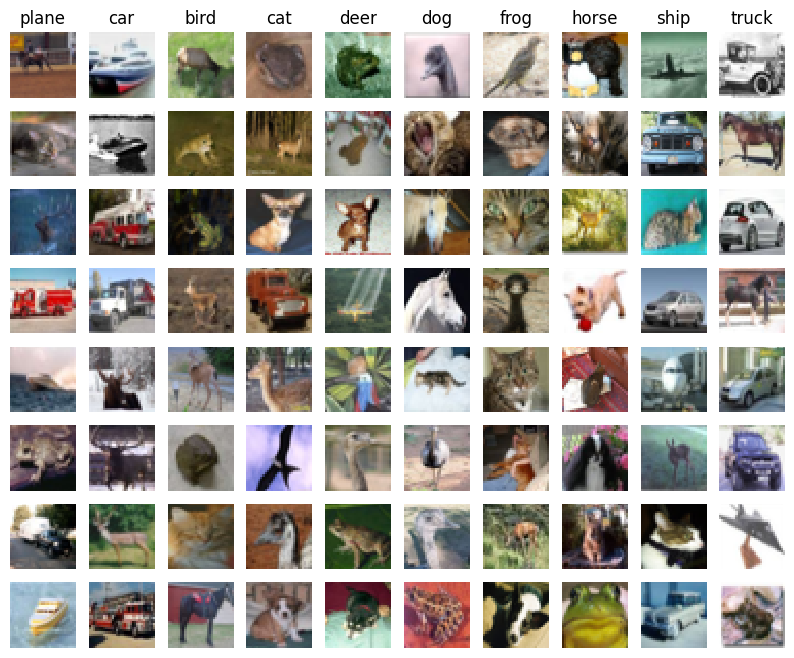

In [23]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$





## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels.

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [24]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 170)
(49000, 169)


In [45]:
from cs231n.classifiers.fc_net import TwoLayerNet
from cs231n.solver import Solver

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10
best_val = -1

data = {
    'X_train': X_train_feats,
    'y_train': y_train,
    'X_val': X_val_feats,
    'y_val': y_val,
    'X_test': X_test_feats,
    'y_test': y_test,
}
best_net = None
std = 1e-4
learning_rates = [0.08,0.1,0.15, 0.2,0.3]
regularization_strengths = [1e-5, 1e-4, 0.5e-3]
for reg in regularization_strengths:
  for lr in learning_rates:

    net = TwoLayerNet(input_dim, hidden_dim, num_classes, weight_scale= std, reg=reg)
    solver = Solver(
    net,
    data,
    update_rule='sgd',
    optim_config={'learning_rate': lr},
    lr_decay=0.95,
    verbose=False
    )
    solver.train()

    val = solver.best_val_acc
    print(f" val = {val}, lr = {lr}, reg = {reg}, std = {std}")
    if val > best_val:
        best_val = val
        best_net = net
        print("NEW BEST:","lr",lr,"reg",reg,"val",val)


################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################


 val = 0.587, lr = 0.08, reg = 1e-05, std = 0.0001
NEW BEST: lr 0.08 reg 1e-05 val 0.587
 val = 0.591, lr = 0.1, reg = 1e-05, std = 0.0001
NEW BEST: lr 0.1 reg 1e-05 val 0.591
 val = 0.609, lr = 0.15, reg = 1e-05, std = 0.0001
NEW BEST: lr 0.15 reg 1e-05 val 0.609
 val = 0.596, lr = 0.2, reg = 1e-05, std = 0.0001
 val = 0.594, lr = 0.3, reg = 1e-05, std = 0.0001
 val = 0.586, lr = 0.08, reg = 0.0001, std = 0.0001
 val = 0.594, lr = 0.1, reg = 0.0001, std = 0.0001
 val = 0.602, lr = 0.15, reg = 0.0001, std = 0.0001
 val = 0.606, lr = 0.2, reg = 0.0001, std = 0.0001
 val = 0.595, lr = 0.3, reg = 0.0001, std = 0.0001
 val = 0.598, lr = 0.08, reg = 0.0005, std = 0.0001
 val = 0.593, lr = 0.1, reg = 0.0005, std = 0.0001
 val = 0.593, lr = 0.15, reg = 0.0005, std = 0.0001
 val = 0.597, lr = 0.2, reg = 0.0005, std = 0.0001
 val = 0.598, lr = 0.3, reg = 0.0005, std = 0.0001


In [46]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 58% accuracy. It is also possible to get >60% accuracy
# with careful tuning.

y_test_pred = np.argmax(best_net.loss(data['X_test']), axis=1)
test_acc = (y_test_pred == data['y_test']).mean()
print(test_acc)

0.589


In [47]:
# Save best model
best_net.save("best_two_layer_net_features.npy")

best_two_layer_net_features.npy saved.
